In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()
sys.path.append(paths.inhouse+'/dif/python')

# from Yesh's DIF_IP script
from pixval import Formatter
import dif_utils as du
from enum import IntEnum
from skimage import measure

green = (0, 255, 0)

Paths defined in paths module:
 paths.ws_dir: /Users/trafferty/workspace
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.images_root: /Users/trafferty/data/images
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_dir: /Users/trafferty/tmp
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.data_root: /Users/trafferty/data
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.projects_root: /Users/trafferty/data/projects


In [2]:
DIF1_ip_config = {
           "rMin": 750,
           "rMax": 1980,
           "timeLapse_us": 4,
           "pxSize_um": 0.345,
           "frameHeight_px": 2160,
           "frameWidth_px": 2560,
           "bg_thresh": 30,
           "circTh": 0.7,
           "maxDropsPerImg": 200,
           "nozzSpacing_um": 141.1082,
           "phaseIDs": [1,2,3],
           "dropDia_um": 10
       }

DIF2_ip_config = {
           "rMin": 900,
           "rMax": 2000,
           "timeLapse_us": 4,
           "pxSize_um": 0.309,
           "frameHeight_px": 2160,
           "frameWidth_px": 2560,
           "bg_thresh": 30,
           "circTh": 0.7,
           "maxDropsPerImg": 200,
           "nozzSpacing_um": 169.333,
           "phaseIDs": [1],
           "dropDia_um": 10
       }

DIF_Synth_ip_config = {
           "rMin": 500,
           "rMax": 2160,
           "timeLapse_us": 4,
           "pxSize_um": 0.309,
           "frameHeight_px": 2160,
           "frameWidth_px": 2560,
           "bg_thresh": 30,
           "circTh": 0.7,
           "maxDropsPerImg": 200,
           "nozzSpacing_um": 131.63,
           "phaseIDs": [1],
           "dropDia_um": 23
       }

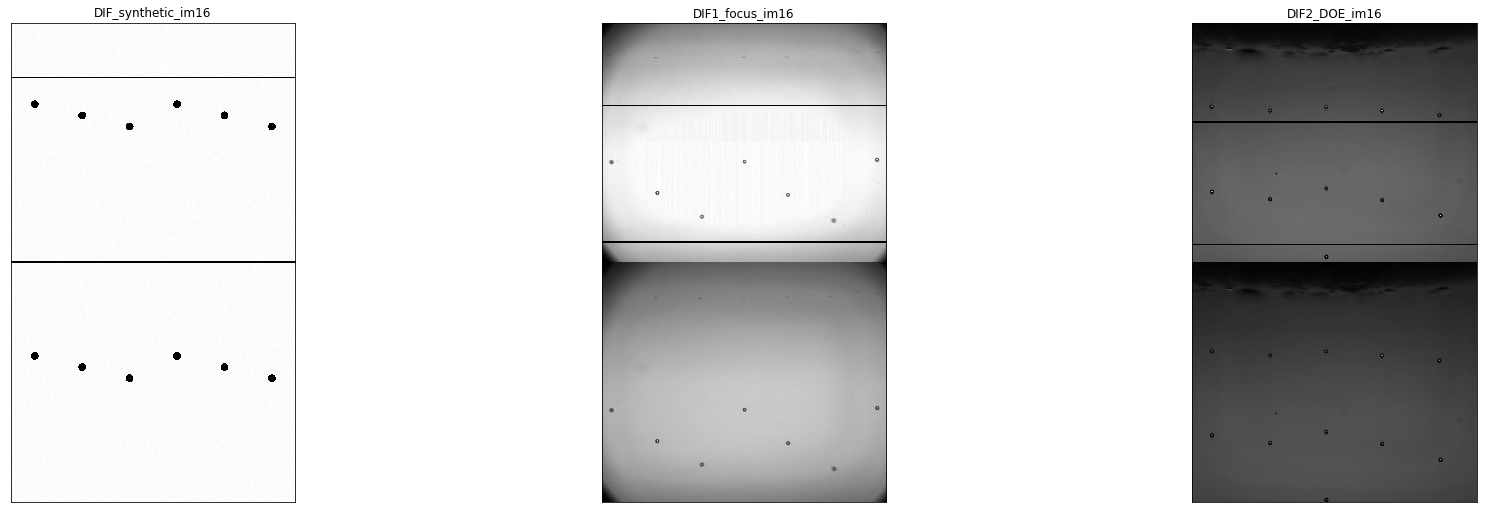

In [3]:
DIF_synthetic_path=paths.tmp_dir+'/DIF/dif_images/DIF_Synthetic_with_proper_metadata.png'
DIF1_focus_path=paths.tmp_dir+'/DIF/dif_images/focus/+0/2017-09-29_09.22.41/DispenserOpt_00006_2017-09-29_09.22.54.png'
DIF2_DOE_path=paths.tmp_dir+'/DIF/DIF2_2018-04-12_12.07.25/DispenserOpt_00001_2018-04-12_12.07.27.png'

DIF_synthetic_im16 = cv2.imread(DIF_synthetic_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
DIF1_focus_im16 = cv2.imread(DIF1_focus_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
DIF2_DOE_im16 = cv2.imread(DIF2_DOE_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# add horiz lines for rMin, rMax
cv2.line(DIF_synthetic_im16, (1, DIF_Synth_ip_config["rMin"]), (DIF_synthetic_im16.shape[1], DIF_Synth_ip_config["rMin"]), (255,255,255), 10)
cv2.line(DIF_synthetic_im16, (1, DIF_Synth_ip_config["rMax"]), (DIF_synthetic_im16.shape[1], DIF_Synth_ip_config["rMax"]), (255,255,255), 10)
cv2.line(DIF1_focus_im16, (1, DIF1_ip_config["rMin"]), (DIF1_focus_im16.shape[1], DIF1_ip_config["rMin"]), (255,255,255), 10)
cv2.line(DIF1_focus_im16, (1, DIF1_ip_config["rMax"]), (DIF1_focus_im16.shape[1], DIF1_ip_config["rMax"]), (255,255,255), 10)
cv2.line(DIF2_DOE_im16, (1, DIF2_ip_config["rMin"]), (DIF2_DOE_im16.shape[1], DIF2_ip_config["rMin"]), (255,255,255), 10)
cv2.line(DIF2_DOE_im16, (1, DIF2_ip_config["rMax"]), (DIF2_DOE_im16.shape[1], DIF2_ip_config["rMax"]), (255,255,255), 10)


#imgplot =plt.imshow(im16, cmap='gray')
#plt.colorbar()

util.plot_imgs([(DIF_synthetic_im16, 'DIF_synthetic_im16'), (DIF1_focus_im16, 'DIF1_focus_im16'), (DIF2_DOE_im16, 'DIF2_DOE_im16')], max_cols = 3)

In [4]:
DIF_sythetic_metadata = du.getMetadata(DIF_synthetic_path)
       
'''
As of 05/01/2018, the metadata should have the following fields:

Keys in both:
'''
metadata_05_01_2018_fields = ['PD_start_us', 'PD_delay_us', 'qsw2_start_us', 'drop_pattern_gap_us', 'git-sha', 'double_shutter', 'qsw1_start_us', 'ExperimentID', 
                              'DispenseBitmapFile', 'Location', 'ImageID', 'lamp1_start_us', 'Camera', 'HeadSerialNumber', 'cam1_int_start_us', 'MonomerID', 
                              'Waveform', 'start_time_us', 'lamp2_start_us', 'git-branch', 'Magnification', 'cam3_int_start_us', 'double_shutter_delay_us', 
                              'drop_latency_us', 'Nozzle', 'DIF_Version', 'cam2_int_start_us', 'NozzleID', 'cycle_time_us', 'Phase', 'Row', 'Loop_Count', 
                              'Total_Loops', 'ExperimentType', 'SecondaryNozzles', 'PrimaryNozzles', 'HeadName', 'Mean_Time_per_Loop', 'Est_Completion_Time', 
                              'ExperimentIndex', 'Run_Mode', 'Sample_Clock', 'Global_Voltage', 'Elapsed_Time', 'elapsed_ms', 'ImageFile', 'ExpFolder']

'''
...broken down into the following categories:
'''    

exp_fields = [ 
 'git-sha', 'git-branch','double_shutter', 'ExperimentID','Location', 'Camera', 'HeadSerialNumber', 
 'MonomerID', 'Magnification', 'SecondaryNozzles', 'PrimaryNozzles', 'HeadName', 'ExpFolder', 'DIF_Version']

loop_fields = ['PD_delay_us',  'DispenseBitmapFile',  'ImageID',  'Waveform', 'double_shutter_delay_us',  
 'Nozzle', 'NozzleID', 'Phase', 'Row', 'Loop_Count', 'Total_Loops', 'ExperimentType', 'ExperimentIndex']

DIF_Server_fields = [ 'ImageFile', 'Mean_Time_per_Loop', 'Est_Completion_Time', 'Run_Mode', 'Elapsed_Time', 'elapsed_ms']

xaar_fields = ['Sample_Clock', 'Global_Voltage']
 
timing_fields = ['PD_start_us', 'qsw2_start_us', 'drop_pattern_gap_us', 'qsw1_start_us', 'lamp1_start_us', 'drop_latency_us',
 'cam1_int_start_us', 'start_time_us', 'lamp2_start_us', 'cam3_int_start_us', 'cam2_int_start_us', 'cycle_time_us',]

all_fields = exp_fields + loop_fields + DIF_Server_fields + xaar_fields + timing_fields 

required_fields = exp_fields + loop_fields

#print(all_fields)

# first let's make sure all_fields is made up of all of metadata_05_01_2018_fields:
for k in metadata_05_01_2018_fields:
    if k not in all_fields:
        print("all_fields missing: ", k)

# Ok, now see if synth img has any fields that are not in all_fields
for k in DIF_sythetic_metadata.keys():
    if k not in all_fields:
        print("synth has field not in all_fields: ", k)
        
# And, most important, are there any missing required fields
for k in required_fields:
    if k not in DIF_sythetic_metadata:
        print("synth missing required field: ", k)


In [5]:
DIF1_focus_metadata_dict = du.getMetadata(DIF1_focus_path)
DIF2_metadata_dict = du.getMetadata(DIF2_DOE_path)

# For our test processing images (focus and DIF2), see what fields they are missing
for k in required_fields:
    if k not in DIF1_focus_metadata_dict:
        print("focus missing required field: %s setting to %s"% (k, DIF_sythetic_metadata[k]) )
        DIF1_focus_metadata_dict[k] = DIF_sythetic_metadata[k]
for k in required_fields:
    if k not in DIF2_metadata_dict:
        print("DIF2 missing required field: %s setting to %s"% (k, DIF_sythetic_metadata[k]) )
        DIF2_metadata_dict[k] = DIF_sythetic_metadata[k]

# then tweak them if necessary:
DIF1_focus_metadata_dict["PrimaryNozzles"] = "3,0,6"
DIF1_focus_metadata_dict["SecondaryNozzles"] = "1,2,4,5"

DIF2_metadata_dict["PrimaryNozzles"] = "2,0,1,3,4"
DIF2_metadata_dict["SecondaryNozzles"] = ""
DIF2_metadata_dict["HeadName"] = "OceF1Chip"
DIF2_metadata_dict["Location"] = "DIF2 Station"

print(DIF1_focus_metadata_dict)

focus missing required field: SecondaryNozzles setting to 1,2,4,5
focus missing required field: PrimaryNozzles setting to 3,0
focus missing required field: HeadName setting to Xaar100x
focus missing required field: ExpFolder setting to /media/DIF_DATA/images/Rel_Test_2018-05-01_16.30.25
focus missing required field: ExperimentType setting to DispenseOpt
focus missing required field: ExperimentIndex setting to 0
DIF2 missing required field: git-sha setting to ce5787839b30ec51a7671e4c465a284793ceb1c1
DIF2 missing required field: git-branch setting to dif_branch
DIF2 missing required field: Location setting to DIF Station
DIF2 missing required field: Camera setting to Andor
DIF2 missing required field: Magnification setting to 20x
DIF2 missing required field: SecondaryNozzles setting to 1,2,4,5
DIF2 missing required field: HeadName setting to Xaar100x
DIF2 missing required field: ExpFolder setting to /media/DIF_DATA/images/Rel_Test_2018-05-01_16.30.25
DIF2 missing required field: DIF_Vers

In [46]:
from collections import namedtuple
ROI = namedtuple('ROI', ['startY', 'endY', 'startX', 'endX'])
KEYPOINT = namedtuple('KEYPOINT', ['pt', 'size'])

test_keypoint = KEYPOINT(pt=[0.9, 5.6], size=8.3)

def sliceIMG(img, roi):
    return (img[roi.startY:roi.endY, roi.startX:roi.endX])

def findBLOBs(img, minArea, maxArea):
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 100;
    params.maxThreshold = 150;
#     params.minThreshold = 8
#     params.maxThreshold = 255
    params.minThreshold = 100;
    params.maxThreshold = 200;

    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = .1

    # # Filter by Convexity
    params.filterByConvexity = False
    # params.minConvexity = 0.87

    # # Filter by Inertia
    params.filterByInertia = False
    # params.minInertiaRatio = 0.9

    params.filterByColor = False
    params.blobColor = 0
    
    params.filterByArea = True
#     params.minArea = 4 * np.pi
#     params.maxArea = 100 * np.pi
#     params.minArea = 20    Used for Focus notebook...
#     params.maxArea = 500   Used for Focus notebook...
    params.minArea = minArea
    params.maxArea = maxArea

    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs.
    keypoints = detector.detect(img)
    return keypoints

def findDrop1(img8, minArea, maxArea, tag="", debug=True):
    plot_list = []
    plot_list.append( (img8,'roi:%s'%tag) )
    
    keypoints = findBLOBs(img8, minArea, maxArea)
    if debug: print( "[findROI] num keypoints found: ", len(keypoints))

    if len(keypoints):
        max_size = 0
        index_of_max_size = -1
        for idx, kp in enumerate(keypoints):
            x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
            if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))
            if kp.size > max_size:
                max_size = kp.size
                index_of_max_size = idx

            if debug:
    #             plot_list.append( (roi,'roi:%s'%tag) )
                cv2.putText(img8, str(idx), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0,0,25), 3)
                cv2.circle(img8, (x, y), int(dia/2), (0,0,25),2)
                cv2.line(img8, (x, y-dia), (x, y+dia), (0,0,25), 3)
                cv2.line(img8, (x-dia, y), (x+dia, y), (0,0,25), 3)
                #plot_list.append( (col_img,'Keypoints') )
                
        index_of_max_size = 0
                
        if debug:
            util.plot_imgs(plot_list)
        return True, keypoints[index_of_max_size]

#         kp = keypoints[index_of_max_size]
#         x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
#         roi = img8.copy()[y-int(roi_width/2):y+int(roi_width/2), 1:col_width]

#         if debug:
# #             plot_list.append( (roi,'roi:%s'%tag) )
#             cv2.circle(img8, (x, y), int(dia/2), (0,0,255),2)
#             cv2.line(img8, (x, y-dia), (x, y+dia), (0,0,255), 3)
#             cv2.line(img8, (x-dia, y), (x+dia, y), (0,0,255), 3)
#             #plot_list.append( (col_img,'Keypoints') )
#         #cv2.rectangle(img8, (sx, sy), (sx+w, sy+h), (0,0,0), 10) # two corners: (startX, startY), (endX, endY)                

    
#     if len(keypoints):
#         return True, roi
    else:
        return False, None
    
def findDrop2(img8, minArea, maxArea, tag="", debug=True):
    if debug:
        plot_list = []
        plot_list.append( (img8,'roi:%s'%tag) )

    found = False
    keypoint = None
    
    rStep = 1
    cStep = 1
    circTh = 0.7
    minSzInPx = 400/(rStep*rStep)
    maxSzInPx = 1600/(rStep*rStep)
    maxDropsPerImg = 200
    timeLapse_us =  metadata_dict['double_shutter_delay_us']
    pxSize_um = ip_config['pxSize_um']

    
    iRef_th = du.simplePreProcAndBinarize(img8)

    # Find, label and size up the blobs
    labelArrRef = measure.label(iRef_th)
    RegPropsRef = measure.regionprops(labelArrRef)
    numBlobsRef = len(RegPropsRef)
    blobCentroidsRef = np.array([RegPropsRef[i].centroid for i in range(numBlobsRef)])

    # Blob centroids after particle filter
    FiltIdxRef, numGoodBlobsRef = du.pruneBlobs(RegPropsRef, circTh, minSzInPx, maxSzInPx)

    if (numGoodBlobsRef <= 0 or numGoodBlobsRef > maxDropsPerImg):
        print("Bad reference image - %d drops detected" % (numGoodBlobsRef))
    else:
        if debug: print("numGoodBlobsRef: %d" % (numGoodBlobsRef))
        FiltIdxRef = FiltIdxRef[0:numGoodBlobsRef]
        blobCentFiltRef = blobCentroidsRef[FiltIdxRef[0:numGoodBlobsRef]]
        RegPropsRefFilt = [RegPropsRef[i] for i in FiltIdxRef[0:numGoodBlobsRef]]
        
        max_size = 0
        index_of_max_size = -1
        for idx, RegProp in enumerate(RegPropsRefFilt):
            x, y, dia = int(RegProp.centroid[0]), int(RegProp.centroid[1]), int(RegProp.equivalent_diameter)
            if debug: print("[findROI] (%d, %d), dia: %d, area: %f" % (x, y, dia, np.pi*dia))
            if dia > max_size:
                max_size = dia
                index_of_max_size = idx

#             if debug:
#                 cv2.putText(img8, str(idx), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0,0,25), 3)
#                 cv2.circle(img8, (x, y), int(dia/2), (0,0,25),2)
#                 cv2.line(img8, (x, y-dia), (x, y+dia), (0,0,25), 3)
#                 cv2.line(img8, (x-dia, y), (x+dia, y), (0,0,25), 3)

        found = True
        keypoint = KEYPOINT(pt=[RegPropsRefFilt[0].centroid[1], RegPropsRefFilt[0].centroid[0]], size=RegPropsRefFilt[0].equivalent_diameter)
    
    if debug:
        util.plot_imgs(plot_list)

    return found, keypoint

findDrop = findDrop2

In [47]:
def calcNozzleColROIs(im16, metadata_dict):
    rows, cols = im16.shape
    midX, midY = int(cols/2), int(rows/2)

    top_nozzle_col_ROI_lst = []
    bot_nozzle_col_ROI_lst = []

    roi_width = 150

    primary_nozzles = [int(x) for x in metadata_dict["PrimaryNozzles"].replace(',', ' ').split()]
    secondary_nozzles = [int(x) for x in metadata_dict["SecondaryNozzles"].replace(',', ' ').split()]

    num_cols = len(primary_nozzles)+len(secondary_nozzles)
    coi = primary_nozzles[0]
    col_width = int(cols/num_cols)

    print("num_cols: ", num_cols)
    print('coi: ', coi)
    print('col_width: ', col_width)

    for i in range(num_cols):
        startY = ip_config["rMin"]
        endY   = ip_config["rMax"]
        startX = i*col_width
        endX   = startX+col_width
        roi = ROI(startY=startY, endY=endY, startX=startX, endX=endX)
        top_nozzle_col_ROI_lst.append(ROI(startY=startY, endY=endY, startX=startX, endX=endX))
        bot_nozzle_col_ROI_lst.append(ROI(startY=midY+startY, endY=midY+endY, startX=startX, endX=endX))
        
    return top_nozzle_col_ROI_lst, bot_nozzle_col_ROI_lst

In [48]:
def findDropROIs(nozzle_col_lst):
    drop_roi_lst = []

    for idx, nozzle_col_roi in enumerate(nozzle_col_lst):
        print("Processing Top-Nozzle Col %d"%idx)
        minArea=10
        maxArea=200
        noz_col_img = sliceIMG(im16, nozzle_col_roi)
        plot_list.append((noz_col_img, "Top-Nozzle Col %d"%idx))
        found, kp = findDrop(du.convert16BitTo8Bit(noz_col_img), minArea, maxArea, tag="Top-%d"%idx, debug=False)
        #found, roi_img = findDrop(du.convert16BitTo8Bit(getROI(im16, nozzle_col_roi)), tag="Top-%d"%idx, debug=False)
        if found:
            x, y, dia = int(kp.pt[0]), int(kp.pt[1]), int(kp.size)
            print("[%d] Dia=%d" % (idx, dia))

            # correct x,y for original image coords
            x = x+nozzle_col_roi.startX
            y = y+nozzle_col_roi.startY

            drop_roi_lst.append( ROI(startY=y-int(roi_width/2), endY=y+int(roi_width/2), startX=x-int(roi_width/2), endX=x+int(roi_width/2)) )

    return drop_roi_lst


num_cols:  7
coi:  3
col_width:  365
Processing Top-Nozzle Col 0
[0] Dia=33
Processing Top-Nozzle Col 1
[1] Dia=34
Processing Top-Nozzle Col 2
[2] Dia=32
Processing Top-Nozzle Col 3
[3] Dia=30
Processing Top-Nozzle Col 4
[4] Dia=33
Processing Top-Nozzle Col 5
[5] Dia=33
Processing Top-Nozzle Col 6
[6] Dia=34
Processing Top-Nozzle Col 0
[0] Dia=34
Processing Top-Nozzle Col 1
[1] Dia=34
Processing Top-Nozzle Col 2
[2] Dia=32
Processing Top-Nozzle Col 3
[3] Dia=31
Processing Top-Nozzle Col 4
[4] Dia=33
Processing Top-Nozzle Col 5
[5] Dia=32
Processing Top-Nozzle Col 6
[6] Dia=35


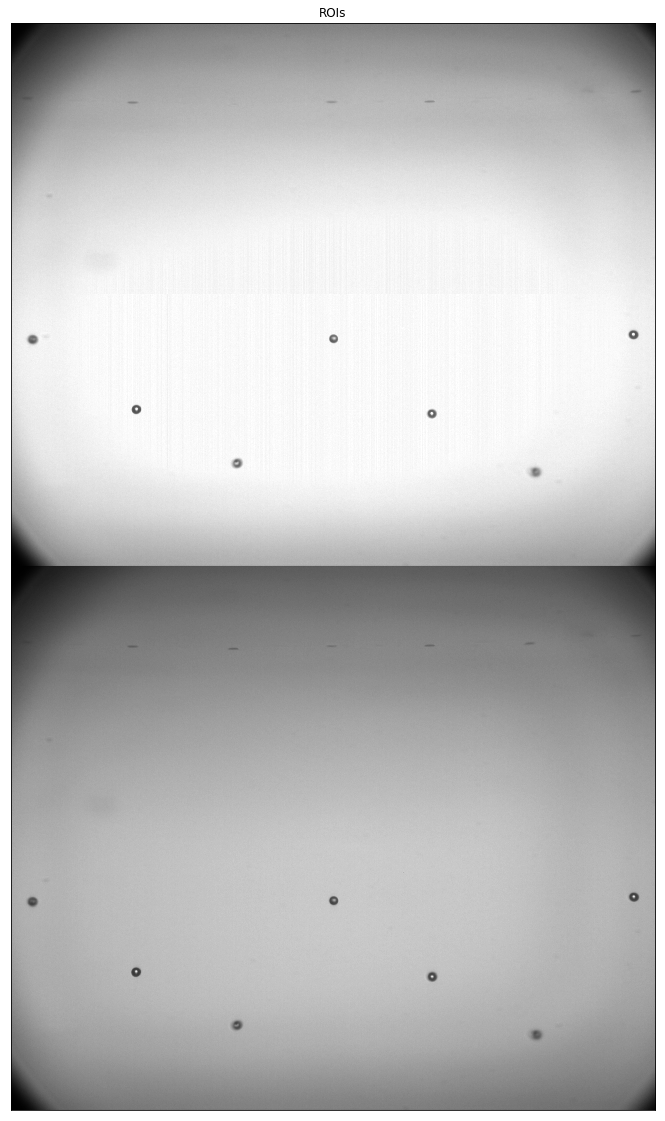

In [51]:
test_data = [ (DIF_synthetic_path, DIF_sythetic_metadata, DIF_Synth_ip_config),
              (DIF1_focus_path, DIF1_focus_metadata_dict, DIF1_ip_config),
              (DIF2_DOE_path, DIF2_metadata_dict, DIF2_ip_config)]
test_idx = 1

img_path = test_data[test_idx][0]
metadata_dict = test_data[test_idx][1]
ip_config = test_data[test_idx][2]

im16 = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

top_nozzle_col_ROI_lst, bot_nozzle_col_ROI_lst = calcNozzleColROIs(im16, metadata_dict)

top_drop_roi_lst = findDropROIs(top_nozzle_col_ROI_lst)
bot_drop_roi_lst = findDropROIs(bot_nozzle_col_ROI_lst)

plot_list = []
for idx, drop_roi in enumerate(top_drop_roi_lst):
    drop_roi_img = sliceIMG(im16, drop_roi)
    #cv2.rectangle(im16, (drop_roi.startX,drop_roi.startY), (drop_roi.endX, drop_roi.endY), (255, 0, 255), 1)    # upper-left and lower-right corners (X, Y)
    #plot_list.append((drop_roi_img, "Top-%d"%idx))
for idx, drop_roi in enumerate(bot_drop_roi_lst):
    drop_roi_img = sliceIMG(im16, drop_roi)
    #cv2.rectangle(im16, (drop_roi.startX,drop_roi.startY), (drop_roi.endX, drop_roi.endY), (255, 0, 255), 1)    # upper-left and lower-right corners (X, Y)
    #plot_list.append((drop_roi_img, "Top-%d"%idx))

plot_list.append((im16, "ROIs"))
util.plot_imgs(plot_list, max_cols = 1, fig_size = 20)

col 0: 35020102643
col 1: 249301540534
col 2: 63708635807
col 3: 159859070555
col 4: 158454245927
col 5: 19296620732
col 6: 161143529863
col 7: 21572869378
col 8: 129580843101
col 9: 23866874296
col 10: 88881553259
col 11: 72395504548
col 12: 10775416750
col 13: 88535292126


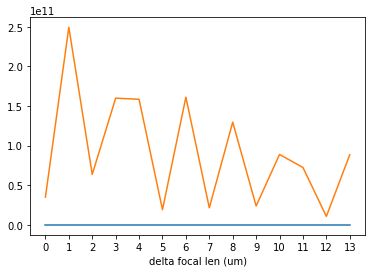

Rank: 0 -> col 1: 249301540534
Rank: 1 -> col 6: 161143529863
Rank: 2 -> col 3: 159859070555
Rank: 3 -> col 4: 158454245927
Rank: 4 -> col 8: 129580843101
Rank: 5 -> col 10: 88881553259
Rank: 6 -> col 13: 88535292126
Rank: 7 -> col 11: 72395504548
Rank: 8 -> col 2: 63708635807
Rank: 9 -> col 0: 35020102643
Rank: 10 -> col 9: 23866874296
Rank: 11 -> col 7: 21572869378
Rank: 12 -> col 5: 19296620732
Rank: 13 -> col 12: 10775416750


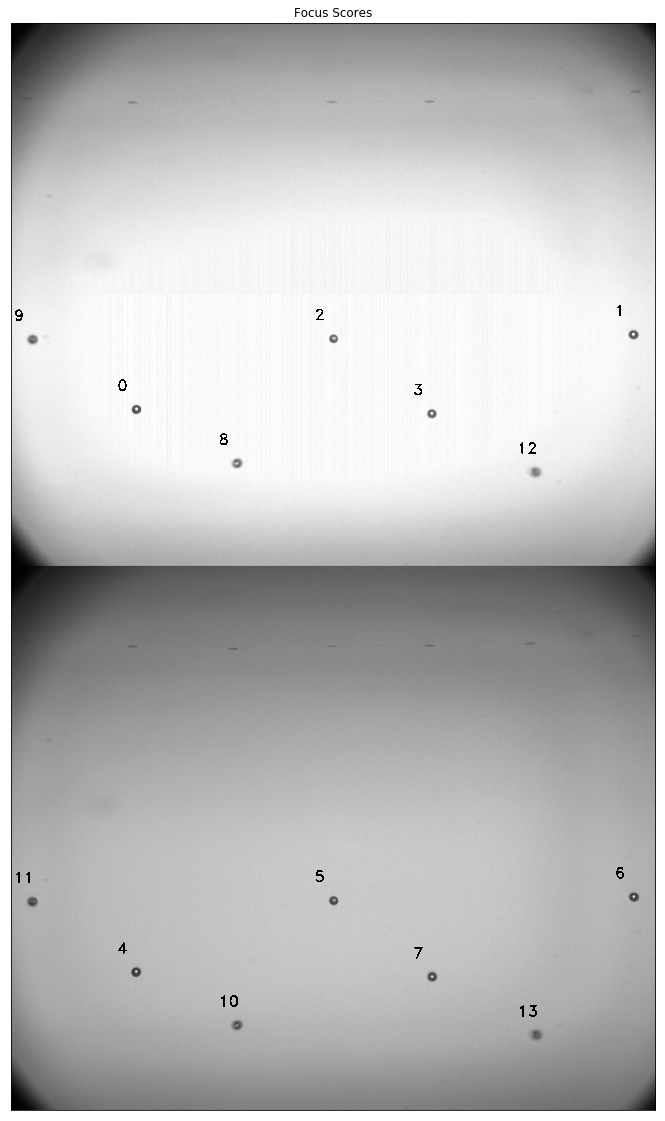

In [65]:
results = []
plot_list = []
ksize=7

top_and_bot_roi_lst = top_drop_roi_lst+bot_drop_roi_lst

for idx, drop_roi in enumerate(top_and_bot_roi_lst):
    drop_roi_img = sliceIMG(im16, drop_roi)
    # Calc Laplacian of image
    lap_img = cv2.Laplacian(drop_roi_img, cv2.CV_64F, ksize=ksize)
    # Cal variance of Laplacian
    focus_measure = lap_img.var()
    #plot_list.append( ((lap_img), "%d: %d" % (idx, int(focus_measure)) ) )
    results.append( (idx, int(focus_measure)) )
    print("col %d: %010d" % (idx, int(focus_measure)))

plt.plot(results)
x_labels = [i[0] for i in results]
plt.xticks(range(len(x_labels)), x_labels)
plt.xlabel('delta focal len (um)')
plt.show()

results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

im2 = im16.copy()
for idx, result in enumerate(results_sorted):
    col = result[0]
    focus_measure = result[1]
    print("Rank: %d -> col %d: %010d" % (idx, col, focus_measure))
    drop_roi = top_and_bot_roi_lst[col]
    cv2.putText(im2, str(idx), (drop_roi.startX, drop_roi.startY), cv2.FONT_HERSHEY_DUPLEX, 2, (0,0,25), 3)

plot_list.append((im2, "Focus Scores"))
util.plot_imgs(plot_list, max_cols = 1, fig_size = 20)


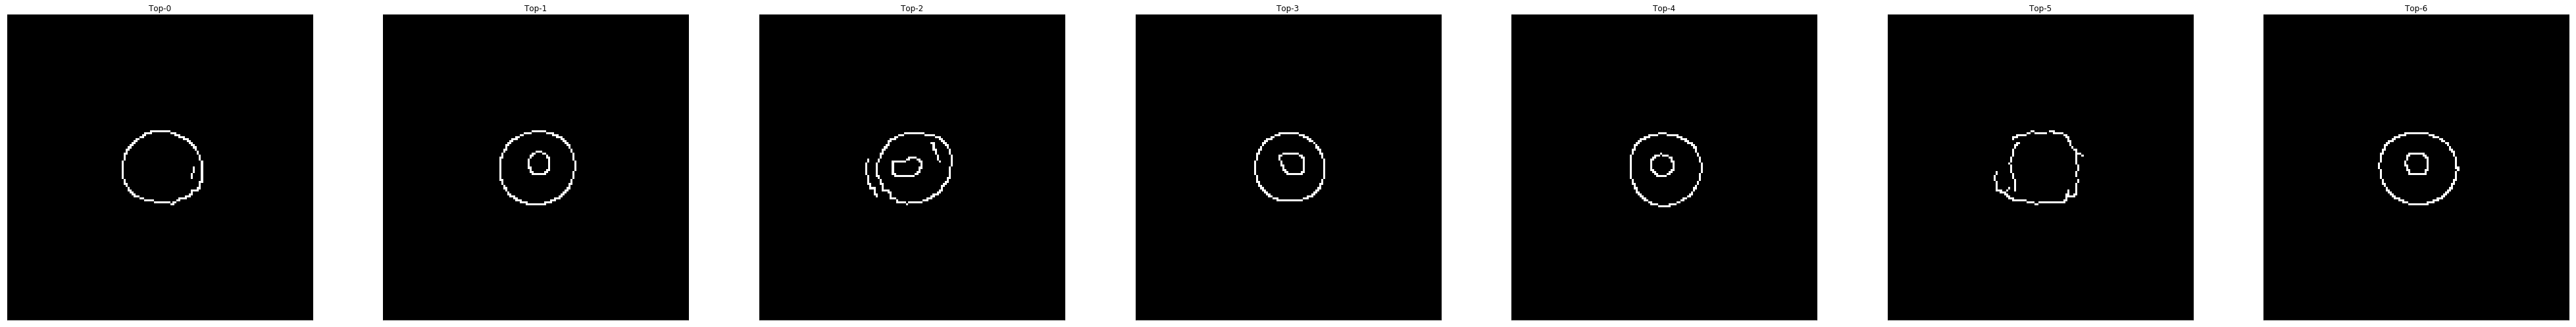

In [67]:
from skimage import feature

plot_list = []

top_and_bot_roi_lst = top_drop_roi_lst+bot_drop_roi_lst

for idx, drop_roi in enumerate(top_drop_roi_lst):
    drop_roi_img = sliceIMG(im16, drop_roi)
    canny_img = feature.canny(drop_roi_img, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False)
    plot_list.append((canny_img, "Top-%d"%idx))

util.plot_imgs(plot_list, max_cols = len(plot_list))

### From DIF_ImageProcessor.readAndCropImages

In [64]:
#im16 = cv2.imread('../images/DispenserOpt_00097_2016-10-31_14.03.19.png', cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# First make 2D by slicing out one channel
if len(im16.shape) == 3:
    im16 = im16[:,:,1]

# if 16bit, convert to 8bit
if im16.dtype.name.find('16') >= 0:
    im8 = du.convert16BitTo8Bit(im16)
else:
    im8 = im16

# now subimage into ref and tgt
if (im8.shape[0] == 2*frameHeight_px):
    ITgt = im8[frameHeight_px+rMin:frameHeight_px+rMax:rStep,cMin:cMax:cStep]

IRef = im8[rMin:rMax:rStep,cMin:cMax:cStep]
IRef16 = im16[rMin:rMax:rStep,cMin:cMax:cStep]

util.plot_imgs([(IRef, 'IRef'), (ITgt, 'ITgt')], max_cols = 2)

NameError: name 'bu' is not defined

### Preprocess and find blobs in Ref image

In [ ]:
def simplePreProcAndBinarize(img):
    gauBlur1 = cv2.GaussianBlur(img,(3,3),0)
    gauBlur2 = cv2.GaussianBlur(img,(11,11),0)
    diffOfGau = gauBlur1-gauBlur2
    dog_med = cv2.medianBlur(diffOfGau, 5, 0)
    ret, im_thresh = cv2.threshold(dog_med,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    util.plot_imgs([(img, 'img'), (gauBlur1, 'gauBlur1'),(gauBlur2, 'gauBlur2'),(diffOfGau, 'diffOfGau'),(dog_med, 'dog_med'),(im_thresh, 'im_thresh')], max_cols = 2)
    return im_thresh


In [ ]:
# Ref image processing
#---------------------
# Preprocess and binarize reference image
#iRef_th = bu.preprocAndBinarizeImg(iRef, blurKernelSize, tophatKernalSize, minThVal, maxThVal, thresholdType)
#iRef_th = bu.simplePreProcAndBinarize(IRef16)
iRef_th = simplePreProcAndBinarize(IRef)

# Find, label and size up the blobs
labelArrRef = measure.label(iRef_th)

# Measure properties of labeled image regions.
#  http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
RegPropsRef = measure.regionprops(labelArrRef)

numBlobsRef = len(RegPropsRef)
print("There are %d region properties found:" % (numBlobsRef))
      
# for i in range(numBlobsRef):
#     print(RegPropsRef[i].centroid)

blobCentroidsRef = np.array([RegPropsRef[i].centroid for i in range(numBlobsRef)])

util.plot_imgs([(iRef_th, 'iRef_th')], max_cols = 2)

### What did we find? Filter out according to circTh, minSzInPx, maxSzInPx

In [ ]:
# Blob centroids after particle filter
FiltIdxRef, numGoodBlobsRef = bu.pruneBlobs(RegPropsRef, circTh, minSzInPx, maxSzInPx)
print("numGoodBlobsRef: %d" % (numGoodBlobsRef))

In [ ]:
# Good blob indices are 0:numGoodBlobs-1 and bad blob indices numGoodBlobs+1:-1
FiltIdxRef = FiltIdxRef[0:numGoodBlobsRef]

blobCentFiltRef = blobCentroidsRef[FiltIdxRef[0:numGoodBlobsRef]]
RegPropsRefFilt = [RegPropsRef[i] for i in FiltIdxRef[0:numGoodBlobsRef]]

print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsRef), len(RegPropsRefFilt)))


### Now process the Target image...

In [ ]:
iTgt_th = bu.simplePreProcAndBinarize(ITgt)
labelArrTgt = measure.label(iTgt_th)
RegPropsTgt = measure.regionprops(labelArrTgt)
numBlobsTgt = len(RegPropsTgt)
blobCentroidsTgt = np.array([RegPropsTgt[i].centroid for i in range(numBlobsTgt)])
FiltIdxTgt, numGoodBlobsTgt = bu.pruneBlobs(RegPropsTgt, circTh, minSzInPx, maxSzInPx)
FiltIdxTgt = FiltIdxTgt[0:numGoodBlobsTgt]
blobCentFiltTgt = blobCentroidsTgt[FiltIdxTgt[0:numGoodBlobsTgt]]
RegPropsTgtFilt = [RegPropsTgt[i] for i in FiltIdxTgt[0:numGoodBlobsTgt]]
print('# of Initial ref blobs = %d, # blobs after pruning = %d'%(len(RegPropsTgt), len(RegPropsTgtFilt)))
util.plot_imgs([(iTgt_th, 'iTgt_th')], max_cols = 2)